Batch 0:
IOU: 0.1140
Precision: 1.0000
Recall: 0.1140
F1 Score: 0.2047
Pixel Accuracy: 0.1140
Latency: 3.7571 ms
Inference Time: 0.0038 s
--------------------------------------------------
Batch 1:
IOU: 0.1788
Precision: 1.0000
Recall: 0.1788
F1 Score: 0.3034
Pixel Accuracy: 0.1788
Latency: 4.0069 ms
Inference Time: 0.0040 s
--------------------------------------------------
Batch 2:
IOU: 0.0043
Precision: 1.0000
Recall: 0.0043
F1 Score: 0.0085
Pixel Accuracy: 0.0043
Latency: 4.2660 ms
Inference Time: 0.0043 s
--------------------------------------------------
Batch 3:
IOU: 0.0014
Precision: 1.0000
Recall: 0.0014
F1 Score: 0.0028
Pixel Accuracy: 0.0014
Latency: 4.3715 ms
Inference Time: 0.0044 s
--------------------------------------------------
Batch 4:
IOU: 0.0148
Precision: 1.0000
Recall: 0.0148
F1 Score: 0.0291
Pixel Accuracy: 0.0148
Latency: 4.2885 ms
Inference Time: 0.0043 s
--------------------------------------------------
Batch 5:
IOU: 0.0074
Precision: 1.0000
Recall: 0.0074
F

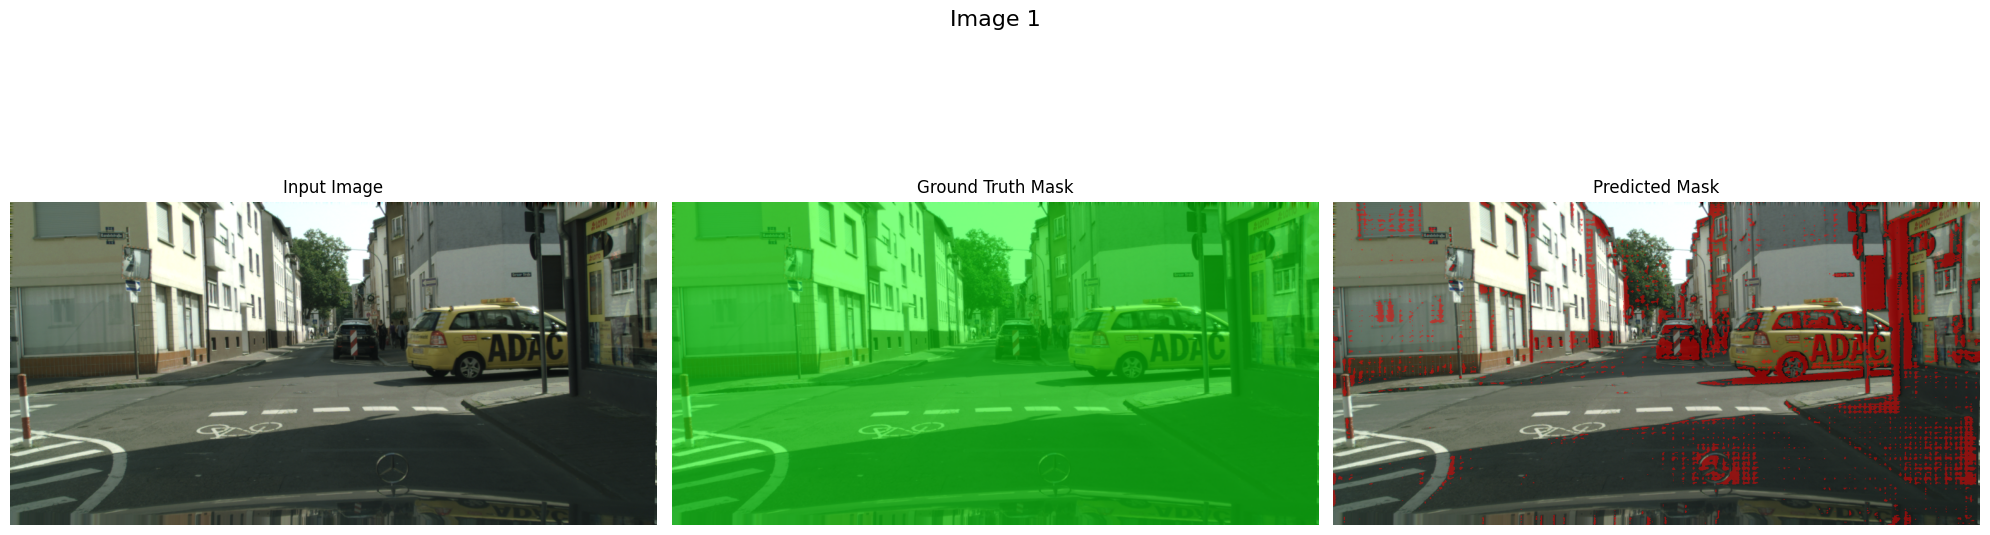

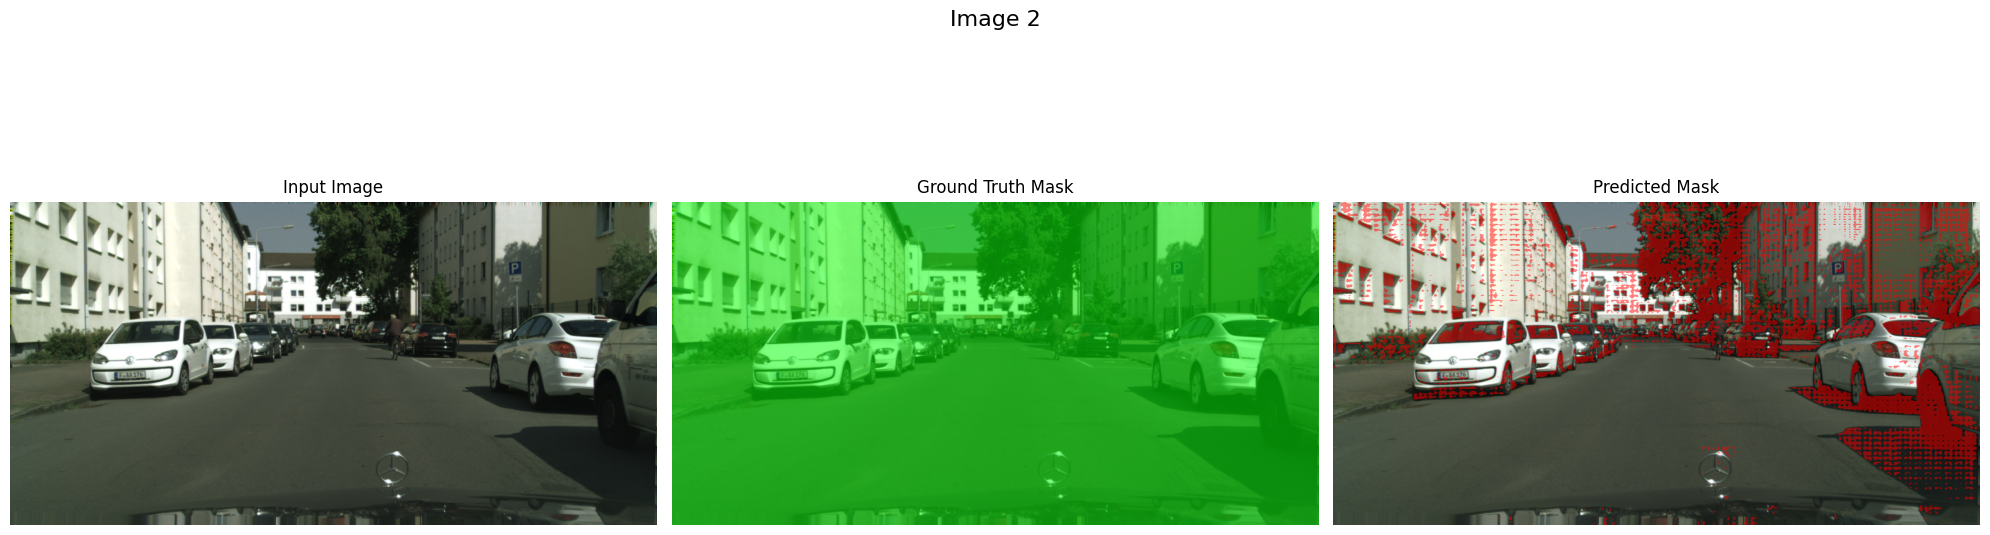

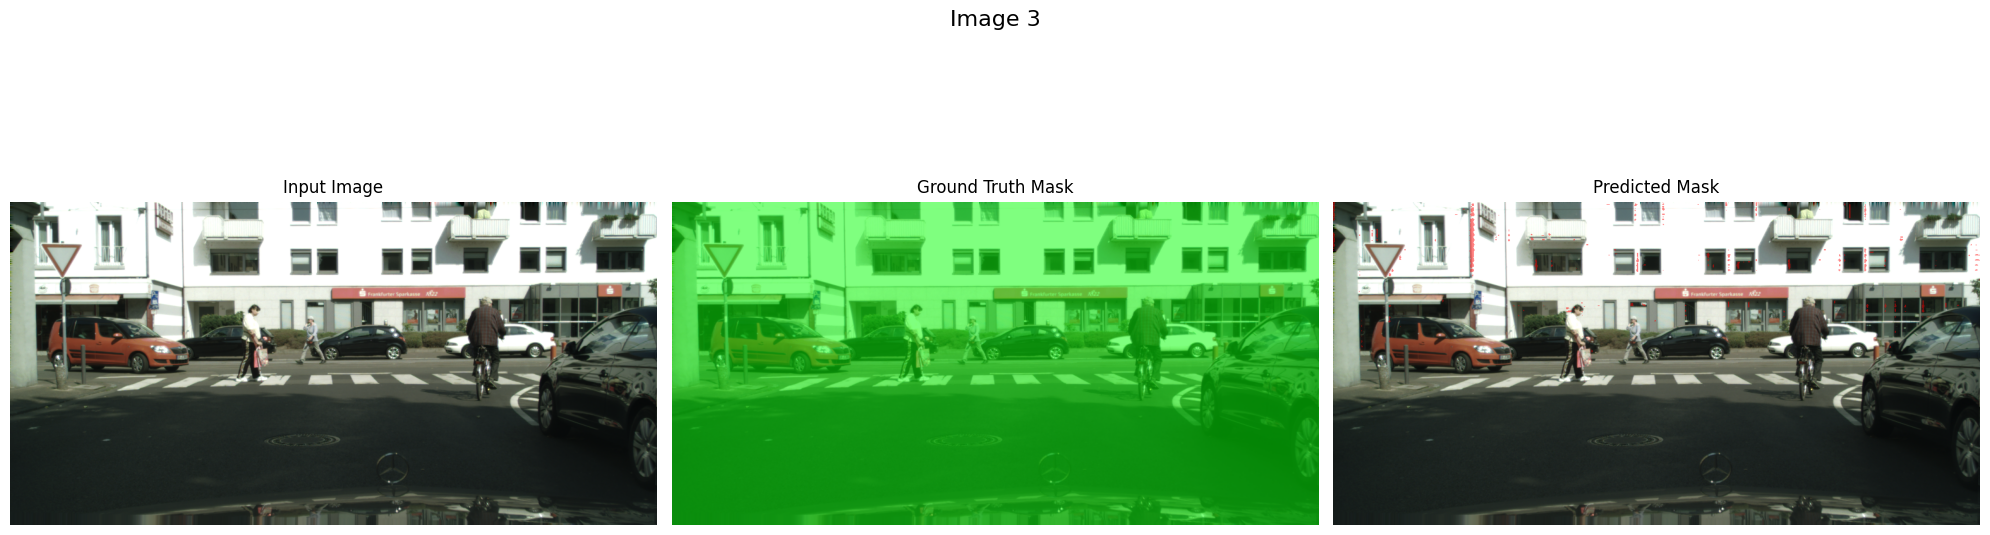

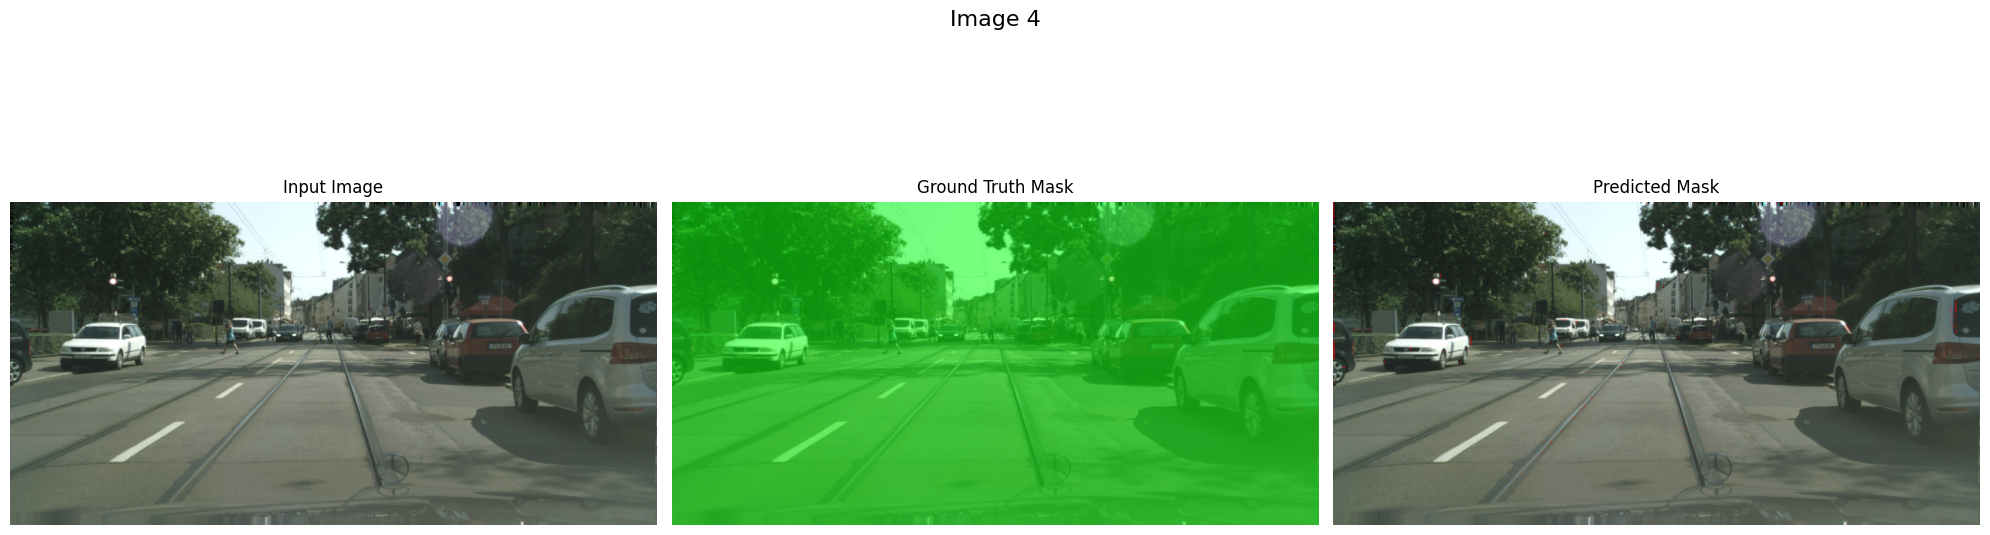

In [3]:
import numpy as np
import torch
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import time  # For CPU timing

# ===========================
# 1. Dataset Definition
# ===========================

class CityscapesDataset(Dataset):
    """
    Dataset class for Cityscapes (validation dataset with labels).
    """
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        # Collect all image and mask file paths
        self.image_files = []
        self.mask_files = []
        for city in os.listdir(image_dir):
            city_image_path = os.path.join(image_dir, city)
            city_label_path = os.path.join(label_dir, city)
            if os.path.isdir(city_image_path) and os.path.isdir(city_label_path):
                for file_name in os.listdir(city_image_path):
                    if file_name.endswith('_leftImg8bit.png'):
                        img_path = os.path.join(city_image_path, file_name)
                        mask_file_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                        mask_path = os.path.join(city_label_path, mask_file_name)
                        if os.path.exists(mask_path):
                            self.image_files.append(img_path)
                            self.mask_files.append(mask_path)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Returns:
            image: Resized RGB image as a NumPy array.
            mask: Resized grayscale mask as a NumPy array.
        """
        img_path = self.image_files[idx]
        mask_path = self.mask_files[idx]
        
        image = cv2.imread(img_path)[..., ::-1]  # Convert BGR to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize image and mask to 1024 size while maintaining aspect ratio
        r = min(1024 / image.shape[1], 1024 / image.shape[0])
        new_size = (int(image.shape[1] * r), int(image.shape[0] * r))
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, new_size, interpolation=cv2.INTER_NEAREST)

        return image, mask

# ===========================
# 2. Paths and DataLoader Setup
# ===========================

# Define paths to Cityscapes validation dataset images and labels
val_image_dir = "segment-anything-2/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/val"  # Replace with actual validation image path
val_label_dir = "segment-anything-2/cityscapes/gtFine_trainvaltest/gtFine/val"       # Replace with actual validation label path

# Create dataset and dataloader for validation
val_dataset = CityscapesDataset(val_image_dir, val_label_dir)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# ===========================
# 3. Model Loading
# ===========================

# Load original SAM2 model checkpoint (not fine-tuned, with .pt extension)
original_sam2_checkpoint = "segment-anything-2/checkpoints/sam2_hiera_small.pt"  # Replace with actual path
model_cfg = 'sam2_hiera_s.yaml'  # Ensure this config file is correctly set up
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build SAM2 model
sam2_model = build_sam2(model_cfg, None, device=device)

# Load the checkpoint and extract the state_dict
checkpoint = torch.load(original_sam2_checkpoint, map_location=device)

# Check if the model is wrapped in a dictionary with the key 'model'
if 'model' in checkpoint:
    state_dict = checkpoint['model']
else:
    state_dict = checkpoint  # Assume checkpoint is already the state dict

# Load the state dict into the model
sam2_model.load_state_dict(state_dict)
sam2_model.to(device)
sam2_model.eval()  # Set model to evaluation mode

# Initialize SAM2ImagePredictor
predictor = SAM2ImagePredictor(sam2_model)

# ===========================
# 4. Metrics Initialization
# ===========================

ious, precisions, recalls, f1s, latencies, pixel_accuracies = [], [], [], [], [], []

# For storing images and masks to display later
images_to_display = []
pred_masks_to_display = []
true_masks_to_display = []

# ===========================
# 5. Utility Functions
# ===========================

def apply_color_overlay(image, mask, color, alpha=0.5):
    """
    Apply a color overlay to the mask and blend it with the original image.

    Args:
        image (np.array): Original RGB image.
        mask (np.array): Binary mask.
        color (list): RGB color for the overlay.
        alpha (float): Transparency factor.

    Returns:
        np.array: Image with color overlay.
    """
    if mask.ndim == 2:
        mask = mask[:, :, np.newaxis]  # Convert to (H, W, 1) for broadcasting
    elif mask.ndim == 3 and mask.shape[2] != 1:
        raise ValueError(f"Expected mask with 1 channel, got shape {mask.shape}")
    
    mask = mask.astype(bool)  # Convert mask to boolean
    overlay = image.copy()  # Copy original image

    # Create a color mask
    color_mask = np.zeros_like(image, dtype=np.uint8)
    color_mask[:, :] = color

    # Blend the color mask with the original image where the mask is True
    overlay = np.where(mask, (image * (1 - alpha) + color_mask * alpha).astype(np.uint8), overlay)

    return overlay

# ===========================
# 6. Evaluation Loop
# ===========================

with torch.no_grad():
    for batch_idx, (image, true_mask) in enumerate(val_dataloader):
        try:
            # ===========================
            # 6.1 Image Preprocessing
            # ===========================

            image_np = image.squeeze(0).numpy()  # Remove batch dimension
            image_np = np.transpose(image_np, (2, 0, 1))  # Convert to (C, H, W)

            # Convert to tensor and normalize
            image_tensor = torch.from_numpy(image_np).float() / 255.0  # Scale to [0,1]
            if image_tensor.shape[0] != 3:
                raise ValueError(f"Expected 3 channels but got {image_tensor.shape[0]} channels")

            # Normalize using mean and std
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
            image_tensor = (image_tensor.to(device) - mean) / std  # Normalize

            # Convert back to NumPy for predictor
            image_np_normalized = image_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, C)

            # ===========================
            # 6.2 Set Image for Predictor
            # ===========================

            predictor.set_image(image_np_normalized)

            # ===========================
            # 6.3 Retrieve High-Res Features
            # ===========================

            high_res_features = [
                feat_level[-1].unsqueeze(0).to(device).detach()
                for feat_level in predictor._features["high_res_feats"]
            ]

            # ===========================
            # 6.4 Timing Start
            # ===========================

            if device.type == 'cuda':
                low_res_masks_start_time = torch.cuda.Event(enable_timing=True)
                low_res_masks_end_time = torch.cuda.Event(enable_timing=True)
                low_res_masks_start_time.record()
            else:
                start_time = time.time()

            # ===========================
            # 6.5 Model Inference
            # ===========================

            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                points=None, boxes=None, masks=None
            )

            repeat_image = False  # No prompts provided

            low_res_masks, _, _, _ = predictor.model.sam_mask_decoder(
                image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0).to(device).detach(),
                image_pe=predictor.model.sam_prompt_encoder.get_dense_pe().to(device).detach(),
                sparse_prompt_embeddings=sparse_embeddings.to(device).detach(),
                dense_prompt_embeddings=dense_embeddings.to(device).detach(),
                multimask_output=False,
                repeat_image=repeat_image,
                high_res_features=high_res_features
            )

            # ===========================
            # 6.6 Timing End
            # ===========================

            if device.type == 'cuda':
                low_res_masks_end_time.record()
                torch.cuda.synchronize()
                latency_ms = low_res_masks_start_time.elapsed_time(low_res_masks_end_time)  # Milliseconds
            else:
                end_time = time.time()
                latency_ms = (end_time - start_time) * 1000  # Milliseconds

            # ===========================
            # 6.7 Post-Processing
            # ===========================

            pred_mask = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])[0]
            pred_mask_binary = (torch.sigmoid(pred_mask).cpu().numpy() > 0.5).astype(np.uint8)  # Binary mask

            # Ensure masks have shape (H, W)
            if pred_mask_binary.ndim == 3 and pred_mask_binary.shape[0] == 1:
                pred_mask_binary = pred_mask_binary.squeeze(0)
            if true_mask.ndim == 3 and true_mask.shape[0] == 1:
                true_mask_binary = (true_mask.numpy().squeeze(0) > 0).astype(np.uint8)
            else:
                true_mask_binary = (true_mask.numpy() > 0).astype(np.uint8)

        except Exception as e:
            print(f"Error processing batch {batch_idx}: {e}")
            continue

        try:
            # ===========================
            # 6.8 Metrics Calculation
            # ===========================

            # Compute metrics with 'binary' average and handle zero division
            iou_score = jaccard_score(
                true_mask_binary.flatten(),
                pred_mask_binary.flatten(),
                average='binary',
                zero_division=1
            )
            precision_score_val = precision_score(
                true_mask_binary.flatten(),
                pred_mask_binary.flatten(),
                average='binary',
                zero_division=1
            )
            recall_score_val = recall_score(
                true_mask_binary.flatten(),
                pred_mask_binary.flatten(),
                average='binary',
                zero_division=1
            )
            f1_score_val = f1_score(
                true_mask_binary.flatten(),
                pred_mask_binary.flatten(),
                average='binary',
                zero_division=1
            )

            # Compute pixel accuracy
            pixel_accuracy_val = np.mean(true_mask_binary.flatten() == pred_mask_binary.flatten())

            # Append metrics
            ious.append(iou_score)
            precisions.append(precision_score_val)
            recalls.append(recall_score_val)
            f1s.append(f1_score_val)
            latencies.append(latency_ms)
            pixel_accuracies.append(pixel_accuracy_val)

            # ===========================
            # 6.9 Collect Images for Display
            # ===========================

            if len(images_to_display) < 4:
                # Reverse normalization for display
                image_to_show = (image_np_normalized * std.cpu().numpy().reshape(1,1,3) + mean.cpu().numpy().reshape(1,1,3))
                image_to_show = np.clip(image_to_show * 255.0, 0, 255).astype(np.uint8)
                images_to_display.append(image_to_show)
                pred_masks_to_display.append(pred_mask_binary)
                true_masks_to_display.append(true_mask_binary)

            # ===========================
            # 6.10 Print Batch Metrics
            # ===========================

            print(f"Batch {batch_idx}:")
            print(f"IOU: {iou_score:.4f}")
            print(f"Precision: {precision_score_val:.4f}")
            print(f"Recall: {recall_score_val:.4f}")
            print(f"F1 Score: {f1_score_val:.4f}")
            print(f"Pixel Accuracy: {pixel_accuracy_val:.4f}")
            print(f"Latency: {latency_ms:.4f} ms")
            print(f"Inference Time: {latency_ms/1000:.4f} s")
            print("-" * 50)

        except Exception as e:
            print(f"Error calculating metrics for batch {batch_idx}: {e}")
            continue

# ===========================
# 7. Summary Metrics Calculation
# ===========================

mean_iou = np.nanmean(ious) if ious else float('nan')
mean_precision = np.nanmean(precisions) if precisions else float('nan')
mean_recall = np.nanmean(recalls) if recalls else float('nan')
mean_f1 = np.nanmean(f1s) if f1s else float('nan')
mean_latency_ms = np.nanmean(latencies) if latencies else float('nan')
mean_pixel_accuracy = np.nanmean(pixel_accuracies) if pixel_accuracies else float('nan')

print("Summary Metrics:")
print(f"Mean IOU: {mean_iou:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")
print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")
print(f"Mean Latency: {mean_latency_ms:.4f} ms")

# ===========================
# 8. Visualization of Results
# ===========================

# Define colors for ground truth and predicted masks
true_mask_color = [0, 255, 0]  # Green for ground truth
pred_mask_color = [255, 0, 0]  # Red for predicted mask

# Display input images and predicted masks
num_images_to_display = min(4, len(images_to_display))
for i in range(num_images_to_display):
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    fig.suptitle(f"Image {i+1}", fontsize=16)

    # Display Original Image
    axes[0].imshow(images_to_display[i])
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # Display Ground Truth Mask with Color Overlay
    true_overlay = apply_color_overlay(images_to_display[i], true_masks_to_display[i], true_mask_color, alpha=0.5)
    axes[1].imshow(true_overlay)
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Display Predicted Mask with Color Overlay
    pred_overlay = apply_color_overlay(images_to_display[i], pred_masks_to_display[i], pred_mask_color, alpha=0.5)
    axes[2].imshow(pred_overlay)
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()
